# Brick optimisation OOP phase extraction

Created 03/07/2025

Objectives:
* Apply OOP packages from fermionic classification to bosonic states.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [4]:
from tqdm import tqdm

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

# Load data

In [6]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [7]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [8]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [9]:
psi_dict = dict()

In [10]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitons

In [11]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [14]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [15]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*40,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [16]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [17]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [18]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

# Calculate boundary operators

In [32]:
block_width = 4
num_one_sided_iterations = 3
num_two_sided_iterations = 3
num_layers = 10
num_sites = 16
max_virtual_bond_dim = 30

In [33]:
optimizers = list()

for l in cases:
    optimizers.append(list())
    for c in l:
        opt = MPSBrickSolver(
            c,
            num_sites,
            block_width,
            num_layers,
            num_one_sided_iterations,
            num_two_sided_iterations,
            max_virtual_bond_dim=max_virtual_bond_dim
        )
    
        opt.optimise()
    
        optimizers[-1].append(opt)

In [34]:
with open(r'solutions/brick_unitary_solutions.pkl', 'wb') as file:
    pickle.dump(optimizers, file)

## Expectations

In [35]:
interpolation_values = np.round(np.linspace(0, 1, 21), 3)

In [36]:
final_exps = list()

for l in optimizers:
    final_exps.append(list())
    for o in l:
        final_exp = o.flatten_exps()[-1]
        final_exps[-1].append(final_exp)

final_exps = np.array(final_exps)

In [37]:
final_exps.shape

(21, 4)

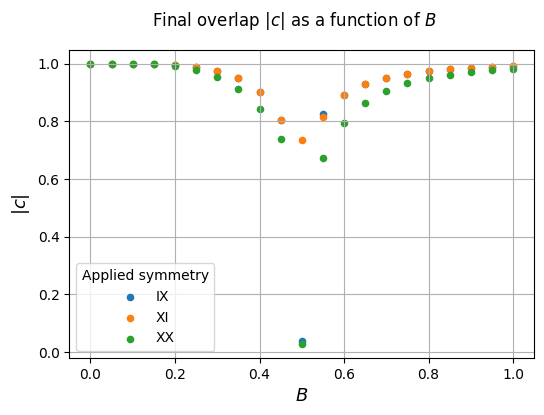

In [69]:
fig, ax = plt.subplots(figsize=(6, 4))

for i in range(1, 4):
    ax.scatter(
        interpolation_values,
        final_exps[:, i],
        label=symmetry_labels[i],
        s=20
    )

ax.grid()
ax.legend(title='Applied symmetry')


ax.set_ylabel(r'$\vert c \vert$', fontsize=13)
ax.set_xlabel('$B$', fontsize=13)

fig.suptitle(r'Final overlap $\vert c \vert$ as a function of $B$')

fig.savefig(r'plots/overlap_function_from_unitary_circuit_bosonic.png', dpi=200)

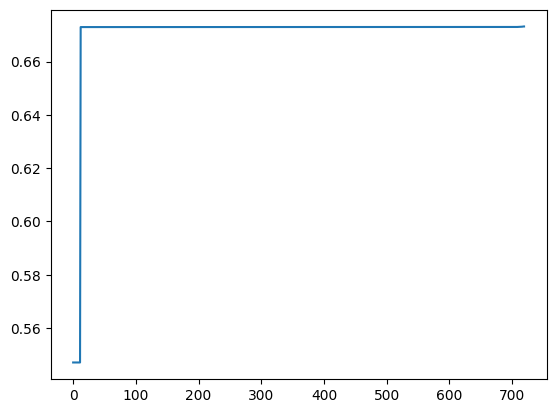

In [39]:
plt.plot(optimizers[11][3].flatten_exps())

# Calculate proj reps

## SPT functions

In [40]:
def calculate_proj_rep_phase(state_g, left_schmidt_values_g, unitary_h,
                             state_gh,
                             left_environment,
                             max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    prod_state, _ = multiply_stacked_unitaries_against_mps(
        unitary_h,
        state_g,
        left_schmidt_values_g,
        max_virtual_bond_dim
    )

    exp = inner_product_b_tensors(prod_state, state_gh, left_environment)

    return exp/(np.abs(exp))

In [41]:
def get_proj_rep_phases(mps_tensors, left_schmidt_values, unitaries,
                        left_environment):
    mps_dict = {
        k: v for k, v in zip(symmetry_labels[1:], mps_tensors)
    }

    schmidt_vals_dict = {
        k: v for k, v in zip(symmetry_labels[1:], left_schmidt_values)
    }

    unitaries_dict = {
        k: v for k, v in zip(symmetry_labels[1:], unitaries)
    }

    out_phases = list()

    for a, b, c in group_products:
        phase = calculate_proj_rep_phase(
            mps_dict[a],
            schmidt_vals_dict[a],
            unitaries_dict[b],
            mps_dict[c],
            left_environment,
            max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
        )

        out_phases.append(phase)

    return out_phases

In [42]:
def get_right_proj_rep_phases_from_optimizers(optimizers):
    mps_tensors = [
        o.top_right_mps_tensors
        for o in optimizers[1:]
    ]

    left_schmidt_values = [
        o.current_right_side_left_schmidt_values
        for o in optimizers[1:]
    ]

    unitaries = [
        o.right_unitaries for o in optimizers[1:]
    ]

    left_environment = optimizers[0].right_side_left_symmetry_environment

    out = get_proj_rep_phases(
        mps_tensors,
        left_schmidt_values,
        unitaries,
        left_environment
    )

    return out

In [43]:
def get_left_proj_rep_phases_from_optimizers(optimizers):
    mps_tensors = [
        o.top_left_mps_tensors
        for o in optimizers[1:]
    ]

    left_schmidt_values = [
        o.current_left_side_right_schmidt_values
        for o in optimizers[1:]
    ]

    unitaries = [
        o.left_unitaries for o in optimizers[1:]
    ]

    left_environment = optimizers[0].left_side_right_symmetry_environment

    out = get_proj_rep_phases(
        mps_tensors,
        left_schmidt_values,
        unitaries,
        left_environment
    )

    return out

## Group data definitions

In [44]:
from itertools import combinations

In [45]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [46]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [47]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [48]:
e, a, b, c = symmetry_labels

In [49]:
group_products = [
    (a, b, c),
    (b, a, c),
    (a, c, b),
    (c, a, b),
    (c, b, a),
    (b, c, a)
]

# Calculate proj reps

## Right side

In [50]:
right_proj_rep_phases = list()

for l in optimizers:

    phases = get_right_proj_rep_phases_from_optimizers(l)

    right_proj_rep_phases.append(phases)

right_proj_rep_phases = np.array(right_proj_rep_phases)

In [52]:
right_proj_rep_phases.shape

(21, 6)

In [53]:
right_proj_rep_phases

array([[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [-1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [-1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [-1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [-1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [54]:
right_proj_rep_phases[:, ::2]/right_proj_rep_phases[:, 1::2]

array([[-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j]])

## Left side

In [55]:
left_proj_rep_phases = list()

for l in optimizers:

    phases = get_left_proj_rep_phases_from_optimizers(l)

    left_proj_rep_phases.append(phases)

left_proj_rep_phases = np.array(left_proj_rep_phases)

In [56]:
left_proj_rep_phases.shape

(21, 6)

In [58]:
left_proj_rep_phases

array([[ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [-1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [-1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [-1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [-1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j],
       [ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1

In [59]:
left_proj_rep_phases[:, ::2]/left_proj_rep_phases[:, 1::2]

array([[-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [-1.+0.j, -1.+0.j, -1.+0.j],
       [-1.-0.j, -1.-0.j, -1.-0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j],
       [ 1.+0.j,  1.+0.j,  1.+0.j]])

## Plots

In [89]:
proj_rep_phases = np.stack([left_proj_rep_phases, right_proj_rep_phases], axis=-1)

In [90]:
gauge_invariant_proj_rep_phase = proj_rep_phases[:, ::2, :]/proj_rep_phases[:, 1::2, :]

In [91]:
gauge_invariant_proj_rep_phase = np.delete(
    gauge_invariant_proj_rep_phase,
    10,
    axis=0
)

In [92]:
gauge_invariant_proj_rep_phase.shape

(20, 3, 2)

In [93]:
delta_gauge_invariant_proj_rep_phase = gauge_invariant_proj_rep_phase.copy()
delta_gauge_invariant_proj_rep_phase[:10]*=-1

In [94]:
delta_gauge_invariant_proj_rep_angle = np.imag(np.log(delta_gauge_invariant_proj_rep_phase))

In [95]:
delta_gauge_invariant_proj_rep_angle.shape

(20, 3, 2)

In [96]:
markers = ['<', '>']

In [97]:
colors = [
    'tab:blue',
    'tab:orange',
    'tab:green'
]   

In [98]:
e, a, b, c = symmetry_labels

In [99]:
symmetry_pair_labels = [
    a + ',' + b,
    a + ',' + c,
    c + ',' + b
]

In [100]:
side_labels = ['Left', 'Right']

In [101]:
plot_bs = np.delete(interpolation_values, 10, axis=0)

In [102]:
plot_bs

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [106]:
delta_gauge_invariant_proj_rep_angle

array([[[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[-0., -0.],
        [-0., -0.],
        [-0., -0.]],

       [[-0., -0.],
        [-0., -0.],
        [-0., -0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[-0., -0.],
        [-0., -0.],
        [-0., -0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[-0., -0.],
        [-0., -0.],
        [-0., -0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [

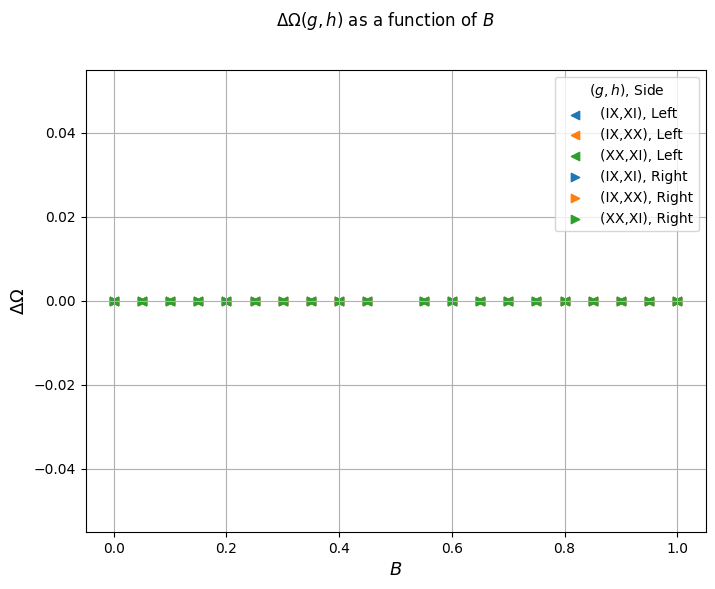

In [104]:
fig, ax = plt.subplots(figsize=(8,6))

for i, (marker, side_label) in enumerate(zip(markers, side_labels)):
    for j, (col, label) in enumerate(zip(colors, symmetry_pair_labels)):
        plt.scatter(
            plot_bs,
            delta_gauge_invariant_proj_rep_angle[:, j, i],
            marker=marker,
            color=col,
            label = f'({label}), {side_label}'
        )

ax.grid()
ax.set_ylabel(r'$\Delta \Omega$', fontsize=13)
ax.set_xlabel('$B$', fontsize=13)

ax.legend(loc='upper right', title='$(g,h)$, Side')

fig.suptitle(r'$\Delta \Omega(g,h)$ as a function of $B$')

fig.savefig(r'plots/delta_proj_rep_angle_from_circuit_bosonic.png', dpi=200)